In [1]:
import pandas as pd
import numpy as np
import math
from pandas_ods_reader import read_ods
import matplotlib.pyplot as plt
import time
from datetime import date
from tqdm.notebook import tqdm as tqdm

table = pd.read_csv("../orari/route.csv", delimiter=";")
time_table = pd.read_csv("../orari/route_time.csv", delimiter=";")
path = "../orari/IndirizziBiblio_21-10-2019.ods"
indirizzi = read_ods(path, 'Questionari_normalizza')
indirizzi=indirizzi.astype({'Cap':'int32'})

dft = pd.read_csv("../distanze/corrected_times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
dfd = pd.read_csv("../distanze/distances_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
num_orders = pd.read_csv("../num_orders.csv", delimiter=";", encoding = "ISO-8859-1")
orders = pd.read_csv("../request_cr.csv", delimiter=",", encoding = "ISO-8859-1")
def translate_name(dframe, fur):
    df = pd.DataFrame({})
    for d in fur.columns:
        df1 = pd.DataFrame([getName(dframe, x) for x in list(fur[d].dropna())], columns = [d])
        df = pd.concat([df,df1], ignore_index=False, axis=1)
    return df
def get_row(df, string):
    return pd.Series(df.index).str.contains(string.strip(), case=False)

def get_column(df, string):
    return pd.Series(df.columns).str.contains(string.strip(), case=False)
def getName(df, nome):
    if nome.lower() == "crema":
        nome ="crema,"
    city = df[get_row(df, nome).values].index[0]
    return city


# Analisi first schedule

In [3]:
first_schedule = translate_name(dft, table)

In [4]:
schedule_cities = []
for i in first_schedule.columns:
    schedule_cities = schedule_cities + list(first_schedule[i].dropna())
total_cities = indirizzi[indirizzi['Calendarizzata (sì/no)'] == 'sì']
num_of_cities = len(set(schedule_cities))
print(f"rapporto tra il numero di città nella schedulazione iniziale e quelle disponibili calendarizzate: la schedulazione non presenta città mancanti\n rapporto: {num_of_cities/len(total_cities)}")
print(f"numero totali di città considerabili: {len(total_cities)}")

rapporto tra il numero di città nella schedulazione iniziale e quelle disponibili calendarizzate: la schedulazione non presenta città mancanti
 rapporto: 1.0
numero totali di città considerabili: 64


# Analisi indirizzi biblio

In [5]:
comuni = total_cities['Comune'].dropna()
com_distribution = list(set([(x, list(comuni).count(x)) for x in list(comuni)]))
print(f"numero di comuni in cui sono presenti le città calendarizzate: {len(com_distribution)}")
print("città con ripetizioni:")
for x in com_distribution:
    if x[1] > 1:
        print(f"{x[0]}, {x[1]}")

province = total_cities['Provincia'].dropna()
pro_distribution = list(set([(x, list(province).count(x)) for x in list(province)]))
print(f"numero di province in cui sono presenti le città calendarizzate: {len(pro_distribution)}")
print(f"distribuzione province:")
for x in pro_distribution: 
    print(f"{x[0]}, {x[1]}")
    
print("da cui si sottolineano le tre città di un'altra provincia:")
print(total_cities[total_cities['Provincia'] != 'CR'][['Comune', 'Provincia']])

numero di comuni in cui sono presenti le città calendarizzate: 60
città con ripetizioni:
Cremona, 4
Crema, 2
numero di province in cui sono presenti le città calendarizzate: 4
distribuzione province:
MN, 1
LO, 1
BS, 1
CR, 61
da cui si sottolineano le tre città di un'altra provincia:
              Comune Provincia
18  Casalpusterlengo        LO
69          Manerbio        BS
70           Viadana        MN


# Analisi scambi biblioteche

In [9]:

week = {0: "lunedi", 1:"martedi", 2:"mercoledi", 3:"giovedi", 4:"venerdi", 5:"sabato", 6:"domenica"}
dal = orders['data_richiesta'][0].split(" ")[0]
al = orders['data_richiesta'][len(orders)-1].split(" ")[0]
print(f"numero ordini: {len(orders)}, dal {dal} al {al}")


duemila_16 = []
duemila_17 = []
duemila_18 = []

for i in tqdm(range(len(orders))):
    if orders.loc[i]['data_richiesta'].split(" ")[0].split("-")[0] == '2016':
        duemila_16.append(orders.loc[i])
    elif orders.loc[i]['data_richiesta'].split(" ")[0].split("-")[0] == '2017':
        duemila_17.append(orders.loc[i])
    elif orders.loc[i]['data_richiesta'].split(" ")[0].split("-")[0] == '2018':
        duemila_18.append(orders.loc[i])
print(f"i numeri di ordini sono divisi in: 2016: {duemila_16} " + f"2017: {duemila_17} " + f"2018: {duemila_18}")

numero ordini: 159642, dal 2016-01-01 al 2018-10-21


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



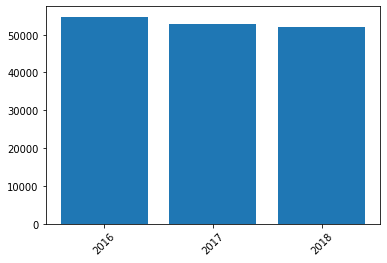

In [10]:
plt.bar(['2016', '2017', '2018'] ,[len(duemila_16), len(duemila_17), len(duemila_18)])
plt.xticks(rotation = 45)
plt.show()

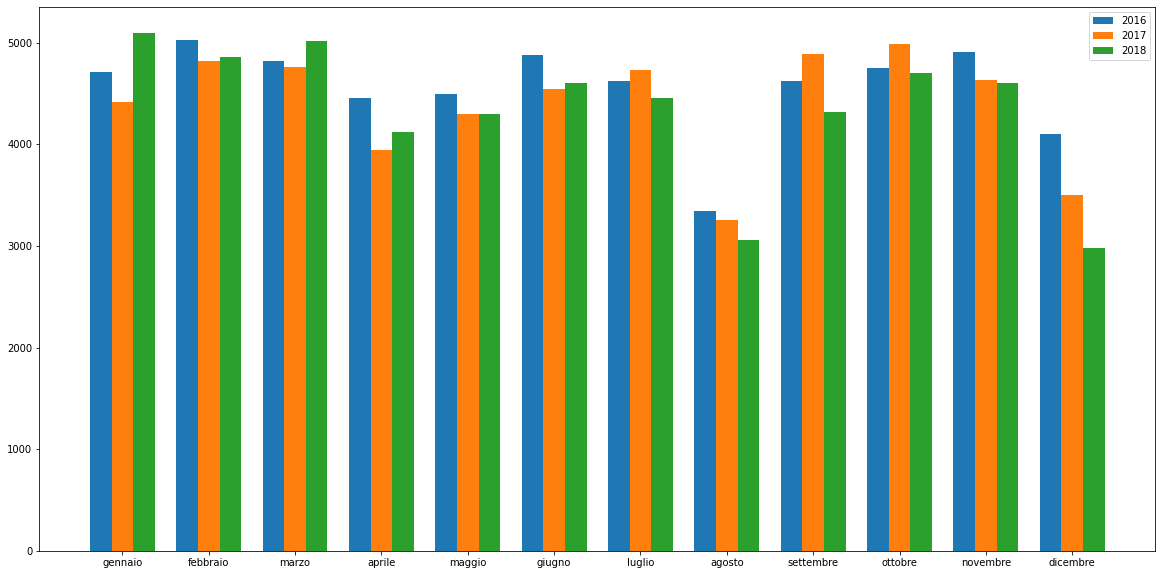

In [67]:
months = ["gennaio", "febbraio", "marzo", "aprile", "maggio", "giugno", "luglio", "agosto", "settembre", "ottobre", "novembre", "dicembre"]


def month_dist(l):
    freq = pd.Series(data = [0]*12, index = months)
    for x in l:
        d = x['data_richiesta'].split(" ")[0]
        m = int(d.split("-")[1])
        freq[m-1] = freq[m-1] + 1
    return freq
w = 0.25

# Set position of bar on X axis
r2 = np.arange(12)
r1 = [x - w for x in r2]
r3 = [x + w for x in r2]

fig, ax = plt.subplots(figsize=[20, 10])
r_16 = ax.bar(r1,month_dist(duemila_16), width = w, label = '2016')
r_17 = ax.bar(r2,month_dist(duemila_17), width = w, label = '2017')
r_18 = ax.bar(r3,month_dist(duemila_18), width = w, label = '2018')

plt.xticks([r for r in range(len(months))], months)
plt.legend()
plt.show()

In [65]:
freq = pd.Series(data = [0,0,0,0,0,0,0], index = ["lunedi", "martedi","mercoledi", "giovedi","venerdi", "sabato", "domenica"])


for x in orders['data_richiesta']:
    d = x.split(' ')[0]
    n = week.get(date.fromisoformat(d).weekday())
    freq[n] = freq[n] + 1

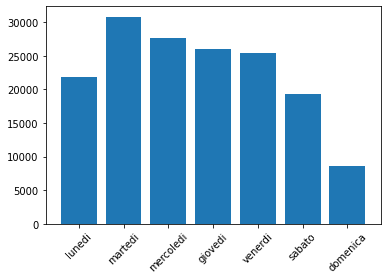

In [66]:
plt.bar(freq.keys() ,freq.values)
plt.xticks(rotation = 45)
plt.show()

In [2]:
def getOccurenceDays(fur1, city):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    l = []
    for d in fur1.columns:
        cur_route1 = fur1[d].dropna()[1:len(fur1[d].dropna())-1]
            
        if city in list(cur_route1):
            l.append(week.index(d))
          
    return list(set(l))

def manage_exception(string):
    if(string.lower().strip() == 'piadena drizzona'):
        return 'Piadena, Platina, 40'
    elif(string.lower().strip() == 'brescia'):
        return 'manerbio, insurrezione nazionale'
    elif(string.lower().strip() == 'centro fumetto a. pazienza' or string.lower().strip() == 'cremona. la piccola biblioteca' or string.lower().strip() == 'uff. bib. cremona'):
        return 'cremona, ugolani dati, 4'
    elif(string.lower().strip() == 'casale cremasco vidolasco'):
        return 'Casale Cremasco-Vidolasco, Roma, 56'
    elif(string.lower().strip() == 'cremona-m.i.t.o.'):
        return 'Cremona, Palosca n. 2'
    elif(string.lower().strip() == 'cremona - manin (scolastica)'):
        return 'Cremona, Felice Cavallotti, 2'
    elif(string.lower().strip() == 'gadesco pieve delmona'):
        return 'Gadesco-Pieve Delmona, Giovanni Lonati 9'
    elif(string.lower().strip() == 'cremona - cda'):
        return 'cremona, sesto 39'
    elif(string.lower().strip() == 'crema'):
        return 'Crema, Civerchi, 9'
    elif(string.lower().strip() == 'martignana di po, libertà, 64'):
        return 'martignana di po, libertà, 64'
    else:
        return string
    
def divide_daily_orders(df, dframe_orders):
    week = {0: "lunedi", 1:"martedi", 2:"mercoledi", 3:"giovedi", 4:"venerdi", 5:"sabato", 6:"domenica"}
    not_considered = 0
    freq = pd.Series(data = [[],[],[],[],[],[],[]], index = ["lunedi", "martedi","mercoledi", "giovedi","venerdi", "sabato", "domenica"])
    for i in tqdm(range(len(dframe_orders))):
        try:
            row = dframe_orders.iloc[i]
            orig = getName(df, manage_exception(row['biblioteca_partenza']))
            dest = getName(df, manage_exception(row['biblioteca_destinazione']))
            if orig == dest:
                not_considered = not_considered + 1
                continue
            try:
                x = row['data_richiesta']
                d = x.split(' ')[0]
                n = week.get(date.fromisoformat(d).weekday())
                temp = [orig, dest, n]
                freq[n].append(temp)
            except:
                print(x)
                break
        except:
            not_considered = not_considered + 1
            continue
                
    return freq, not_considered

#f, not_considered = divide_daily_orders(dft, orders)
#biblioteca_destinazione
#biblioteca_partenza
#data_richiesta
#print(f)

In [3]:
#f.to_csv("frequences.csv", encoding = "ISO-8859-1")

k = pd.read_csv("frequences.csv", encoding = "ISO-8859-1", index_col=0, header=0, squeeze = True)

In [4]:
import ast
week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi", "sabato", "domenica"]
for d in week:
    k[d] = ast.literal_eval(k[d])

list

In [6]:
#works with 2opt or ls schedulation


def take_deliver(fur1, fur2, s, d, day):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    f1_occurrences = getOccurenceDays(fur1, s)
    if f1_occurrences:
        f1_occurrences = list([x for x in f1_occurrences if x>week.index(day)] + [x for x in f1_occurrences if x<=week.index(day)])[0]
    else:
        f1_occurrences = 10
    f2_occurrences = getOccurenceDays(fur2, s)
    if f2_occurrences:
        f2_occurrences = list([x for x in f2_occurrences if x>week.index(day)] + [x for x in f2_occurrences if x<=week.index(day)])[0]
    else:
        f2_occurrences = 10
    
    if f1_occurrences==f2_occurrences==10:
        print("città non nella schedulazione", s, sep=" - ")
    
    take = [f1_occurrences, f2_occurrences].index(min([f1_occurrences, f2_occurrences]))
    day = week[min([f1_occurrences, f2_occurrences])]
    pickup_day = min(f1_occurrences, f2_occurrences)
    
    f1_occurrences = getOccurenceDays(fur1, d)
    if f1_occurrences:
        f1_occurrences = list([x for x in f1_occurrences if x>week.index(day)] + [x for x in f1_occurrences if x<=week.index(day)])[0]
    else:
        f1_occurrences = 10
        
    f2_occurrences = getOccurenceDays(fur2, d)
    if f2_occurrences:
        f2_occurrences = list([x for x in f2_occurrences if x>week.index(day)] + [x for x in f2_occurrences if x<=week.index(day)])[0]
    else:
        f2_occurrences = 10
    deliver = [f1_occurrences, f2_occurrences].index(min([f1_occurrences, f2_occurrences]))
    
    return take, deliver, pickup_day, min(f1_occurrences, f2_occurrences)

def getDistance(s, e):
#     if s == e:
#         return 7
    if s < e:
        return e-s
    if s >= e:
        return 7-(s-e)

def get_stats(occorrenze, fur1, fur2):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi", "sabato", "domenica"]
    freq1 = pd.Series(data = [0,0,0], index = ["pickup", "deliver", "both"])
    freq2 = pd.Series(data = [0,0,0], index = ["pickup", "deliver", "both"])
    mean_service_time = pd.Series(data = [0,0], index = ["total", "n"])
    mean_pickup_time = pd.Series(data = [0,0], index = ["total", "n"])
    
    for day_i in tqdm(range(len(occorrenze))):
        day = occorrenze[day_i]
        for order in day:
            s = order[0]
            d = order[1]
            order_day = order[2]
            #gestire sabato e domenica
            if order_day=="sabato" or order_day=="domenica":
                take, deliver, pickup_day, deliver_day = take_deliver(fur1, fur2, s, d, "venerdi")
            elif order_day == None:
                print(order)
            else:
                take, deliver, pickup_day, deliver_day = take_deliver(fur1, fur2, s, d, order_day)
            
#             if take==deliver==0:
#                 freq1["both"] += 1
#             elif take==0:
#                 freq1["pickup"] +=1
#             elif deliver == 0:
#                 freq1["deliver"] += 1
                
#             if take==deliver==1:
#                 freq2["both"] += 1
#             elif take==1:
#                 freq2["pickup"] +=1
#             elif deliver == 1:
#                 freq2["deliver"] += 1 
              
            if take==deliver==0:
                freq1["both"] += 1
            if take==deliver==1:
                freq2["both"] += 1
            if take==0 and deliver == 1:
                freq1["pickup"] +=1
                freq2["deliver"] += 1 
            if take==1 and deliver == 0:
                freq2["pickup"] +=1
                freq1["deliver"] += 1
            
            mean_service_time["total"] += getDistance(week.index(order_day), deliver_day)
            mean_service_time["n"] += 1
            mean_pickup_time["total"] += getDistance(week.index(order_day), pickup_day)
            mean_pickup_time["n"] += 1
    return freq1, freq2, [round(mean_service_time["total"]/mean_service_time["n"], 2)], [round(mean_pickup_time["total"]/mean_pickup_time["n"], 2)]

In [16]:
fur1 = pd.read_csv("../turni_f/multi_veich_LS1.csv", delimiter=";", encoding = "ISO-8859-1")
fur2 = pd.read_csv("../turni_f/multi_veich_LS2.csv", delimiter=";", encoding = "ISO-8859-1")
fr1, fr2, ms, mp = get_stats(k, fur1, fur2)

In [17]:
fr1.to_csv("fr1_greedy_MVLS.csv", encoding = "ISO-8859-1")
fr2.to_csv("fr2_greedy_MVLS.csv", encoding = "ISO-8859-1")
pd.Series({"ms": ms, "mp": mp}).to_csv("greedy_MVLS_variables.csv", encoding = "ISO-8859-1")


In [101]:
fr1_orig = pd.read_csv("fr1_original_ls.csv", encoding="ISO-8859-1", index_col=0)
fr1_oss = pd.read_csv("fr1_oss.csv", encoding="ISO-8859-1", index_col=0)
fr1_orig_MVLS = pd.read_csv("fr1_original_MVLS.csv", encoding="ISO-8859-1", index_col=0)
fr1_greedy_MVLS = pd.read_csv("fr1_greedy_MVLS.csv", encoding="ISO-8859-1", index_col=0)
fr1_oss_MVLS = pd.read_csv("fr1_optimized_MVLS.csv", encoding="ISO-8859-1", index_col=0)

fr2_orig = pd.read_csv("fr2_original_ls.csv", encoding="ISO-8859-1", index_col=0)
fr2_oss = pd.read_csv("fr2_oss.csv", encoding="ISO-8859-1", index_col=0)
fr2_orig_MVLS = pd.read_csv("fr2_original_MVLS.csv", encoding="ISO-8859-1", index_col=0)
fr2_greedy_MVLS = pd.read_csv("fr2_greedy_MVLS.csv", encoding="ISO-8859-1", index_col=0)
fr2_oss_MVLS = pd.read_csv("fr2_optimized_MVLS.csv", encoding="ISO-8859-1", index_col=0)

v_orig = pd.read_csv("original_variables.csv", encoding="ISO-8859-1", index_col=0, names=["value"]).iloc[1:]
v_oss = pd.read_csv("OSS_variables.csv", encoding="ISO-8859-1", index_col=0, names=["value"] ).iloc[1:]
v_orig_MVLS = pd.read_csv("original_MVLS_variables.csv", encoding="ISO-8859-1", index_col=0, names=["value"] ).iloc[1:]
v_greedy_MVLS = pd.read_csv("greedy_MVLS_variables.csv", encoding="ISO-8859-1", index_col=0, names=["value"] ).iloc[1:]
v_oss_MVLS = pd.read_csv("optimized_MVLS_variables.csv", encoding="ISO-8859-1", index_col=0, names=["value"] ).iloc[1:]

## Furgoncino 1 

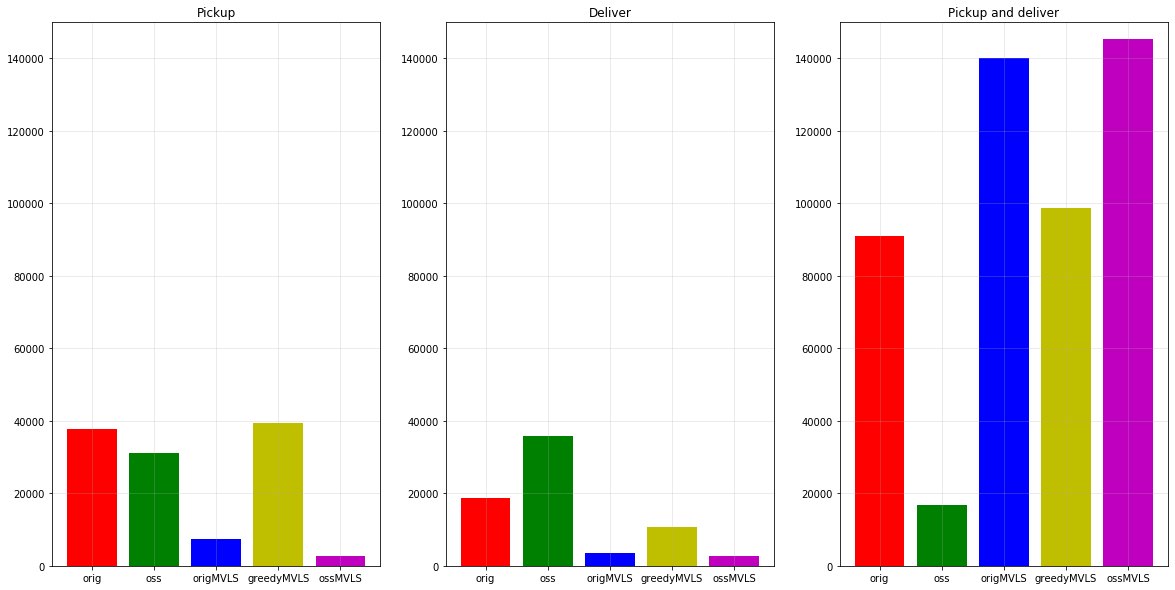

In [102]:
plt.figure(figsize=[20,10])
plt.title("F1 comparison")
plt.subplot(131)
plt.title("Pickup")
plt.bar(range(5), [fr1_orig.loc["pickup"][0], 
                   fr1_oss.loc["pickup"][0], 
                   fr1_orig_MVLS.loc["pickup"][0], 
                   fr1_greedy_MVLS.loc["pickup"][0], 
                   fr1_oss_MVLS.loc["pickup"][0]],
        color="rgbym")
plt.ylim([0,150000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.subplot(132)
plt.title("Deliver")
plt.bar(range(5), [fr1_orig.loc["deliver"][0], 
                   fr1_oss.loc["deliver"][0], 
                   fr1_orig_MVLS.loc["deliver"][0], 
                   fr1_greedy_MVLS.loc["deliver"][0], 
                   fr1_oss_MVLS.loc["deliver"][0]],
        color="rgbym")
plt.ylim([0,150000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.subplot(133)
plt.title("Pickup and deliver")
plt.bar(range(5), [fr1_orig.loc["both"][0], 
                   fr1_oss.loc["both"][0], 
                   fr1_orig_MVLS.loc["both"][0], 
                   fr1_greedy_MVLS.loc["both"][0], 
                   fr1_oss_MVLS.loc["both"][0]],
        color="rgbym")
plt.ylim([0,150000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.show()

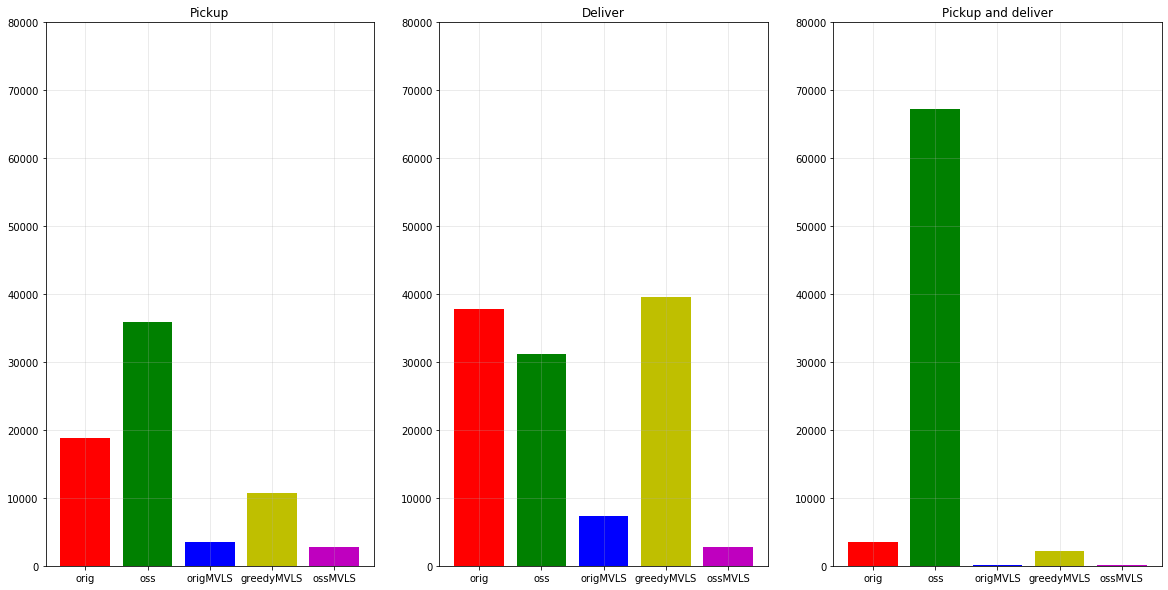

In [104]:
plt.figure(figsize=[20,10])
plt.title("F2 comparison")
plt.subplot(131)
plt.title("Pickup")
plt.bar(range(5), [fr2_orig.loc["pickup"][0], 
                   fr2_oss.loc["pickup"][0], 
                   fr2_orig_MVLS.loc["pickup"][0], 
                   fr2_greedy_MVLS.loc["pickup"][0], 
                   fr2_oss_MVLS.loc["pickup"][0]],
        color="rgbym")
plt.ylim([0,80000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.subplot(132)
plt.title("Deliver")
plt.bar(range(5), [fr2_orig.loc["deliver"][0], 
                   fr2_oss.loc["deliver"][0], 
                   fr2_orig_MVLS.loc["deliver"][0], 
                   fr2_greedy_MVLS.loc["deliver"][0], 
                   fr2_oss_MVLS.loc["deliver"][0]],
        color="rgbym")
plt.ylim([0,80000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.subplot(133)
plt.title("Pickup and deliver")
plt.bar(range(5), [fr2_orig.loc["both"][0], 
                   fr2_oss.loc["both"][0], 
                   fr2_orig_MVLS.loc["both"][0], 
                   fr2_greedy_MVLS.loc["both"][0], 
                   fr2_oss_MVLS.loc["both"][0]],
        color="rgbym")
plt.ylim([0,80000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.show()

In [109]:
ms = []
ms.append(float(v_orig["value"].iloc[0][1:len(v_orig["value"].iloc[1])-1]))
ms.append(float(v_oss["value"].iloc[0][1:len(v_oss["value"].iloc[1])-1]))
ms.append(float(v_orig_MVLS["value"].iloc[0][1:len(v_orig_MVLS["value"].iloc[1])-1]))
ms.append(float(v_greedy_MVLS["value"].iloc[0][1:len(v_greedy_MVLS["value"].iloc[1])-1]))
ms.append(float(v_oss_MVLS["value"].iloc[0][1:len(v_oss_MVLS["value"].iloc[1])-1]))

mp = []
mp.append(float(v_orig["value"].iloc[1][1:len(v_orig["value"].iloc[1])-1]))
mp.append(float(v_oss["value"].iloc[1][1:len(v_oss["value"].iloc[1])-1]))
mp.append(float(v_orig_MVLS["value"].iloc[1][1:len(v_orig_MVLS["value"].iloc[1])-1]))
mp.append(float(v_greedy_MVLS["value"].iloc[1][1:len(v_greedy_MVLS["value"].iloc[1])-1]))
mp.append(float(v_oss_MVLS["value"].iloc[1][1:len(v_oss_MVLS["value"].iloc[1])-1]))

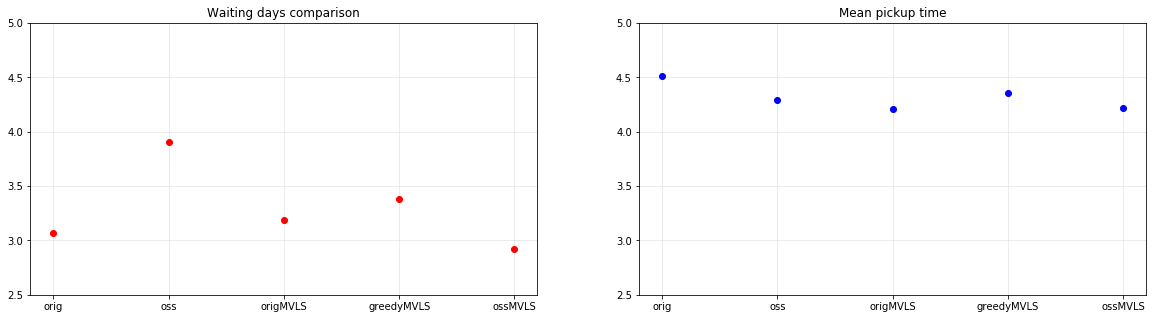

In [122]:
plt.figure(figsize=[20,5])

plt.subplot(121)
plt.title("Waiting days comparison")
plt.plot(ms, 'or')
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.ylim([2.5,5])
plt.grid(alpha=0.3)

plt.subplot(122)
plt.title("Mean pickup time")
plt.plot(mp, 'ob')
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.ylim([2.5,5])
plt.grid(alpha=0.3)

plt.show()